In [130]:
import findspark
findspark.init()

In [131]:
from pyspark.sql import SparkSession,types
from pyspark.sql import functions as F
from pyspark.sql.functions import col,regexp_replace,when,lit, sha2,from_unixtime,from_utc_timestamp, to_utc_timestamp, date_format, json_tuple, when, lit, sum as _sum,split,regexp_replace,trim ,length, substring
from pyspark.sql.types import FloatType, IntegerType
import datetime
import pytz
spark = SparkSession.builder \
    .master("Data Analysis Test") \
    .appName("Atiqah") \
    .getOrCreate()

# Placed your JSON file here
#Retrieve JSON file *copy path of json file here
df = spark.read.json("C:/Users/AtiqahPiakong/Downloads/archive/cc_sample_transaction.json")

print("Before Transform")
df.show()
df.printSchema()

Before Transform
+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|             cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|   2703186189652095|       0|1325376018798532|         1325376018666|         36.011293|        -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:

In [132]:
#TIMESTAMP CONVERSION

print("Before Transform  ")
df.select("trans_date_trans_time","merch_last_update_time","merch_eff_time").show(truncate = False)


#TRANS_DATE_TRANS_TIME (TransactionTime)
# Convert to UTC+8
df_with_timezone = df.withColumn(
    "timestamp_utc_plus_8", 
    from_utc_timestamp(col("trans_date_trans_time"), "Asia/Singapore")
)

#df_with_timezone.select("timestamp_utc_plus_8").show(truncate= False)

# Formatting timestamp to YYYY-MM-DD HH:MM.SSSSSS Z
df_with_formatted_time = df_with_timezone.withColumn(
    "trans_date_trans_time_formatted_time",
    date_format(col("timestamp_utc_plus_8"), "yyyy-MM-dd HH:mm:ss.SSSSSS")  
)
# Result
print("After Transform trans_date_trans_time")
df_with_formatted_time.select("trans_date_trans_time_formatted_time").show(truncate = False)


#MERCH_LAST_UPDATE_TIME (Merchant Last Update Time)
# Given Milliseconds Unix Timestamp

# Convert to seconds
df_with_seconds = df.withColumn(
    "timestamp_s",
    F.when(F.length(F.col("merch_last_update_time").cast("string")) == 13, F.col("merch_last_update_time") / 1000)  
    .otherwise(F.col("merch_last_update_time") / 100) 
)
# Convert to UTC+8/YYYY-MM-DD HH:MM.SSSSSS Z
df_with_formatted_time = df_with_seconds.withColumn(
    "merch_last_update_time_formatted_time",
    date_format(
        from_utc_timestamp(from_unixtime(col("timestamp_s")), "Asia/Singapore"),
        "yyyy-MM-dd HH:mm:ss.SSSSSS"
    )
)
# Result
print("After Transform merch_last_update_time")
df_with_formatted_time.select("merch_last_update_time_formatted_time").show(truncate = False)


#MERCH_EFF_TIME
# Given Unix timestamp in milliseconds

# Convert to seconds
merch_eff_timedf_with_seconds = df.withColumn(
    "timestamp_s_merch_eff_time",
    F.when(F.length(F.col("merch_eff_time").cast("string")) == 16, F.col("merch_eff_time") / 1000000)  
    .otherwise(F.col("merch_eff_time") / 100000) 
)
# Convert to UTC+8/YYYY-MM-DD HH:MM.SSSSSS Z
merch_eff_timedf_with_formatted_time = merch_eff_timedf_with_seconds.withColumn(
    "merch_eff_time_formatted_time",
    date_format(
        from_utc_timestamp(from_unixtime(col("timestamp_s_merch_eff_time")), "Asia/Singapore"),
        "yyyy-MM-dd HH:mm:ss.SSSSSS"
    )
)
# Result
print("After Transform merch_eff_time")
merch_eff_timedf_with_formatted_time.select("merch_eff_time_formatted_time").show(truncate = False)

Before Transform  
+---------------------+----------------------+----------------+
|trans_date_trans_time|merch_last_update_time|merch_eff_time  |
+---------------------+----------------------+----------------+
|2019-01-01 00:00:18  |1325376018666         |1325376018798532|
|2019-01-01 00:00:44  |132537604479          |1325376044867960|
|2019-01-01 00:00:51  |1325376051286         |1325376051506840|
|2019-01-01 00:01:16  |1325376076365         |1325376076794698|
|2019-01-01 00:03:06  |132537618681          |1325376186746376|
|2019-01-01 00:04:08  |1325376248483         |1325376248271406|
|2019-01-01 00:04:42  |1325376282247         |1325376282274130|
|2019-01-01 00:05:08  |1325376308152         |1325376308837349|
|2019-01-01 00:05:18  |1325376318278         |1325376318245892|
|2019-01-01 00:06:01  |1325376361857         |1325376361965234|
|2019-01-01 00:06:23  |1325376383455         |1325376383967287|
|2019-01-01 00:06:53  |1325376413859         |1325376413912233|
|2019-01-01 00:06:56 

In [133]:
#JSON FLATTENING 

from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Parse the personal_detail field to a structured JSON column
df = df.withColumn("personal_detail_parsed", F.from_json(F.col("personal_detail"), personal_detail_schema))

# Extract address field
df = df.withColumn("address", F.col("personal_detail_parsed.address"))

# Extracted address result
df.select("address").show(truncate=False)

# Extract by regular expressions
df = df.withColumn("person_name", F.expr("regexp_extract(personal_detail, '\"person_name\":\"(.*?)\"', 1)"))
df = df.withColumn("gender", F.expr("regexp_extract(personal_detail, '\"gender\":\"(.*?)\"', 1)"))
df = df.withColumn("lat", F.expr("regexp_extract(personal_detail, '\"lat\":\"(.*?)\"', 1)"))
df = df.withColumn("long", F.expr("regexp_extract(personal_detail, '\"long\":\"(.*?)\"', 1)"))
df = df.withColumn("city_pop", F.expr("regexp_extract(personal_detail, '\"city_pop\":\"(.*?)\"', 1)"))
df = df.withColumn("job", F.expr("regexp_extract(personal_detail, '\"job\":\"(.*?)\"', 1)"))
df = df.withColumn("dob", F.expr("regexp_extract(personal_detail, '\"dob\":\"(.*?)\"', 1)"))

df = df.withColumn("street", F.expr("regexp_extract(address, '\"street\":\"(.*?)\"', 1)"))
df = df.withColumn("city", F.expr("regexp_extract(address, '\"city\":\"(.*?)\"', 1)"))
df = df.withColumn("state", F.expr("regexp_extract(address, '\"state\":\"(.*?)\"', 1)"))
df = df.withColumn("zip", F.expr("regexp_extract(address, '\"zip\":\"(.*?)\"', 1)"))

# Result
df.select("person_name","gender","lat","long","city_pop","job","dob","street","city","state","zip").show(truncate = False)

#NAME DERIVATION (PERSON_NAME)
# Function to clean and process the names
def process_names(df):
    
    # Step 1: Clean the names by removing unwanted characters
    df_cleaned = df.withColumn(
        "cleaned_name",
        regexp_replace(col("person_name"), "[^a-zA-Z, ]", ",")  # Remove non-alphabetic characters
    )
    
    # Step 2: Replace sequences of ", ," with ",", treating as missing parts
    df_cleaned = df_cleaned.withColumn(
        "cleaned_name",
        regexp_replace(col("cleaned_name"), ", , ", ",")  # Replace repeated commas+space with single commas
    )
    
    # Step 3: Removed space after commas
    df_cleaned = df_cleaned.withColumn(
        "cleaned_name",
        regexp_replace(col("cleaned_name"), ", ", ",") 
    )
    
     # Step 4: Split the cleaned name into first and last names
    df_split = df_cleaned.withColumn(
       "split_names",
        split(col("cleaned_name"), ",| ")  # Split by commas or spaces
    )
    
    # Step 5: Extract first and last names + handle missing or malformed data
    df_extracted = df_split.withColumn(
        "First",
        when(col("split_names")[0] != "", col("split_names")[0]).otherwise(None)
    ).withColumn(
        "Last",
        when(col("split_names")[1] != "", col("split_names")[1]).otherwise(None)
    )

    # Step 6: Clean up by trimming spaces from first and last names
    df_final = df_extracted.withColumn("First", trim(col("First"))).withColumn("Last", trim(col("Last")))
    
    return df_final

df_processed = process_names(df)

# Result
print("After Transform First and Last Name")
df_processed.select("person_name", "First", "Last").show(truncate=False)

#PII HANDLING (1)- FIRST AND LAST NAME
#PII HANDLING BY MASKING LAST 3 CHARACTERS

from pyspark.sql.functions import col, length, lit, concat, when, expr


df_pii = df_processed.withColumn(
    "masked_First", 
    when(length(col("First")) > 3, 
         concat(expr("substring(First, 1, length(First) - 3)"), lit("*")))  
    .otherwise(lit("*"))  # If name is 3 or fewer characters, mask the entire name
).withColumn(
    "masked_Last", 
    when(length(col("Last")) > 3, 
         concat(expr("substring(Last, 1, length(Last) - 3)"), lit("*")))  
    .otherwise(lit("*"))
)

# Result of masked First and Last Name
print("After Mask First and Last Name")
df_pii.select("masked_First", "masked_Last").show(truncate=False)


#PII HANDLING (2)- CREDIT CARD OWNER ADDRESS(STREET & ZIP)
#PII HANDLING BY MASKING LAST 3 CHARACTERS

#STREET Replaces all digits with "X"
print("Before Mask Address")
df.select("street","city","state","zip").show(truncate=False)

df_masked_street = df.withColumn(
    "masked_street",
    F.regexp_replace(col("street"), r"\d", "X")  
)
print("After Mask Address - Street")
df_masked_street.select("masked_street").show(truncate=False)


#ZIP Keep first 3 digits, mask the rest with "X"
df_masked_zip = df.withColumn(
    "masked_zip",
    F.concat(F.substring(col("zip"), 1, 3), F.lit("XX"))  # Keep first 3 digits, mask the rest
)
print("After Mask Address - Zip")
df_masked_zip.select("masked_zip").show(truncate=False)

#PII HANDLING (3)- CREDIT CARD OWNER DATE OF BIRTH
#PII HANDLING BY MASK THE DAY PART (DD) WITH #
print("Before Mask Date of Birth")
df.select("dob").show(truncate=False)

df = df.withColumn(
    "masked_dob", 
    F.concat(
        F.substring(F.col("dob"), 1, 8),  #Get first 8 characters
        F.lit("##")  # Mask DD with #
    )
)
print("After Mask Date of Birth")
df.select("masked_dob").show(truncate=False)

#PII HANDLING (4)- CREDIT CARD NUMBER
#PII HANDLING BY HASHING
print("Before Hash Credit Card Number")
df.select("cc_num").show(truncate=False)

# Anonymize credit card number by hashing it
df = df.withColumn("cc_num_hash", sha2(df["cc_num"], 256))
 
print("After Hash Credit Card Number")
df.select("cc_num_hash").show(truncate=False)


#MERCHANT (Merchant Name)

print("Before Transform Merchant Name")
df.select("merchant").show(truncate=False)
df = df.withColumn(
        "cleaned_merchant",
        regexp_replace(col("merchant"), "fraud_", "")
    )
print("After Transform Merchant Name")
df.select("cleaned_merchant").show(truncate=False)

+----------------------------------------------------------------------------------------------------+
|address                                                                                             |
+----------------------------------------------------------------------------------------------------+
|{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}                      |
|{"street":"43039 Riley Greens Suite 393","city":"Orient","state":"WA","zip":"99160"}                |
|{"street":"594 White Dale Suite 530","city":"Malad City","state":"ID","zip":"83252"}                |
|{"street":"9443 Cynthia Court Apt. 038","city":"Boulder","state":"MT","zip":"59632"}                |
|{"street":"408 Bradley Rest","city":"Doe Hill","state":"VA","zip":"24433"}                          |
|{"street":"4655 David Island","city":"Dublin","state":"PA","zip":"18917"}                           |
|{"street":"889 Sarah Station Suite 624","city":"Holcomb","state":"KS","z

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+



<Figure size 600x600 with 0 Axes>

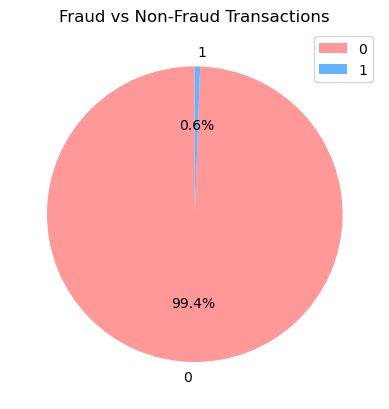

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Group by 'is_fraud' and count the transactions
fraud_counts = df.groupBy('is_fraud').count()

fraud_counts.show()

# Convert the result to pandas DataFrame for plotting
fraud_counts_pd = fraud_counts.toPandas()

# Plot pie chart
plt.figure(figsize=(6,6))
fraud_counts_pd.plot.pie(y='count', labels=fraud_counts_pd['is_fraud'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.ylabel('')
plt.show()

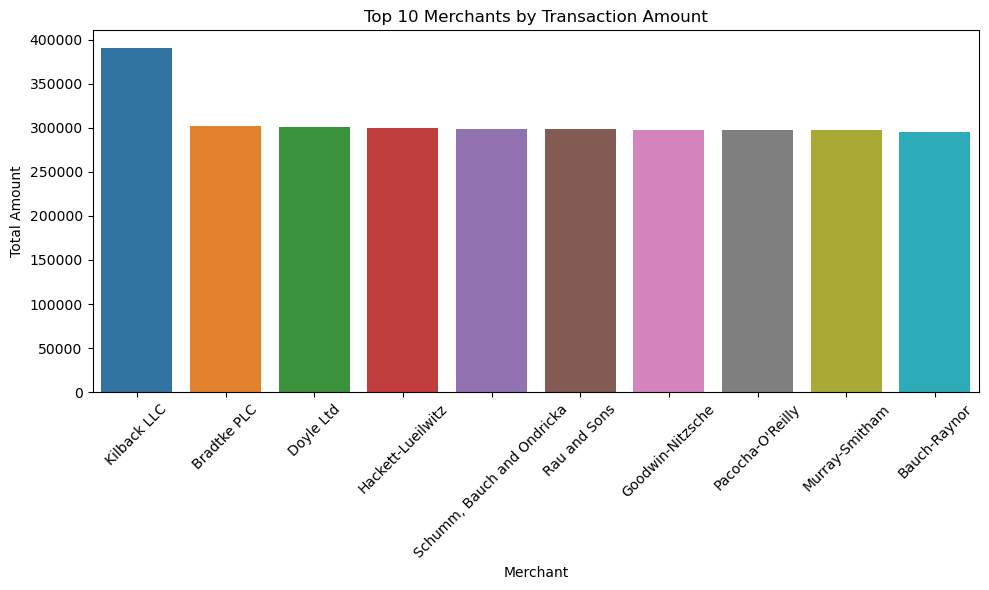

In [135]:
from pyspark.sql.functions import sum as _sum

# Group by merchant and calculate the total amount for each merchant
merchant_amounts = df.groupby('cleaned_merchant').agg(_sum('amt').alias('total_amt'))

# Convert pandas DataFrame for plotting
merchant_amounts_pd = merchant_amounts.toPandas()

# Plot the bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='cleaned_merchant', y='total_amt', data=merchant_amounts_pd.sort_values('total_amt', ascending=False).head(10))
plt.title('Top 10 Merchants by Transaction Amount')
plt.xlabel('Merchant')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

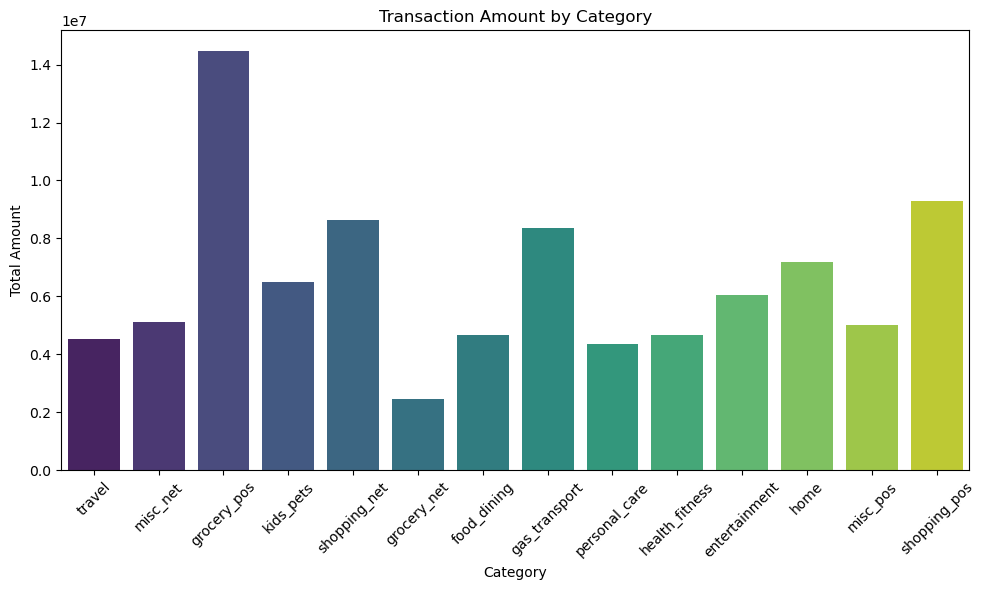

In [136]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by category and calculate the total amount for each category
category_amounts = df.groupBy('category').agg(F.sum('amt').alias('total_amt'))

# Convert to pandas for visualization
category_amounts_pd = category_amounts.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='total_amt', data=category_amounts_pd, palette='viridis')
plt.title('Transaction Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

+------+------+
|gender| count|
+------+------+
|     F|709863|
|     M|586812|
+------+------+



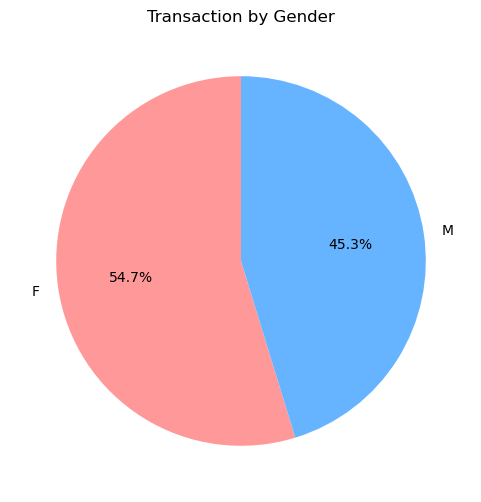

In [116]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Group by gender and count transactions
gender_counts = df.groupBy('gender').count()

gender_counts.show()

# Convert to pandas for visualization
gender_counts_pd = gender_counts.toPandas()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts_pd['count'], 
    labels=gender_counts_pd['gender'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#ff9999', '#66b3ff']
)
plt.title('Transaction by Gender')
plt.ylabel('')
plt.show()